In [1]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop((64, 64), padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
        transforms.RandomResizedCrop((64, 64), scale=(0.07, 1.2), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.RandomRotation((-180, 180)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.CenterCrop((64, 64)),
        transforms.ToTensor(),
    ]),
}

data_dir = '/home/dev2/Sanjana/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

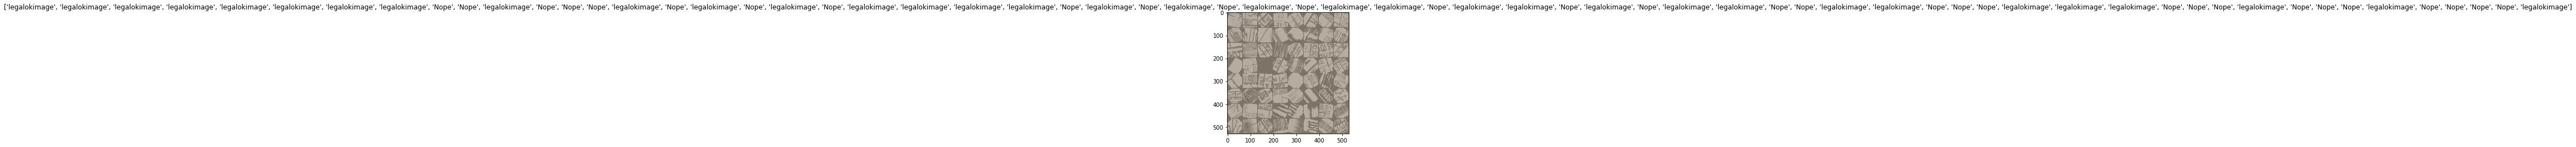

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
from collections import OrderedDict
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).


fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,128)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.4)),
    ('fc2', nn.Linear(128,2)),
    ('output', nn.Softmax(dim=1))
]))
model_ft.fc = fc
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized

optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.0001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 0.5914 Acc: 0.6986
val Loss: 0.7080 Acc: 0.5200

Epoch 1/199
----------
train Loss: 0.4135 Acc: 0.8110
val Loss: 0.5462 Acc: 0.6880

Epoch 2/199
----------
train Loss: 0.3299 Acc: 0.8780
val Loss: 0.4699 Acc: 0.7280

Epoch 3/199
----------
train Loss: 0.2699 Acc: 0.8900
val Loss: 0.3150 Acc: 0.8560

Epoch 4/199
----------
train Loss: 0.2387 Acc: 0.8947
val Loss: 0.2642 Acc: 0.9040

Epoch 5/199
----------
train Loss: 0.2400 Acc: 0.8947
val Loss: 0.2838 Acc: 0.8640

Epoch 6/199
----------
train Loss: 0.2220 Acc: 0.8971
val Loss: 0.3767 Acc: 0.7760

Epoch 7/199
----------
train Loss: 0.2239 Acc: 0.9187
val Loss: 0.3065 Acc: 0.8320

Epoch 8/199
----------
train Loss: 0.2183 Acc: 0.9067
val Loss: 0.2657 Acc: 0.8560

Epoch 9/199
----------
train Loss: 0.2630 Acc: 0.8971
val Loss: 0.2649 Acc: 0.8720

Epoch 10/199
----------
train Loss: 0.2275 Acc: 0.9043
val Loss: 0.2120 Acc: 0.9280

Epoch 11/199
----------
train Loss: 0.2265 Acc: 0.9211
val Loss: 0.2352 Acc

val Loss: 0.2086 Acc: 0.9120

Epoch 97/199
----------
train Loss: 0.2080 Acc: 0.9234
val Loss: 0.2314 Acc: 0.9120

Epoch 98/199
----------
train Loss: 0.1947 Acc: 0.9163
val Loss: 0.2365 Acc: 0.9120

Epoch 99/199
----------
train Loss: 0.2174 Acc: 0.9067
val Loss: 0.2625 Acc: 0.9120

Epoch 100/199
----------
train Loss: 0.2228 Acc: 0.9187
val Loss: 0.2519 Acc: 0.9040

Epoch 101/199
----------
train Loss: 0.1858 Acc: 0.9163
val Loss: 0.2212 Acc: 0.9120

Epoch 102/199
----------
train Loss: 0.2131 Acc: 0.9187
val Loss: 0.2136 Acc: 0.9120

Epoch 103/199
----------
train Loss: 0.2263 Acc: 0.8971
val Loss: 0.2509 Acc: 0.9120

Epoch 104/199
----------
train Loss: 0.1864 Acc: 0.9378
val Loss: 0.2349 Acc: 0.9120

Epoch 105/199
----------
train Loss: 0.1823 Acc: 0.9306
val Loss: 0.2074 Acc: 0.9120

Epoch 106/199
----------
train Loss: 0.2138 Acc: 0.9306
val Loss: 0.2058 Acc: 0.9200

Epoch 107/199
----------
train Loss: 0.2167 Acc: 0.9043
val Loss: 0.2376 Acc: 0.9120

Epoch 108/199
----------
tr

train Loss: 0.2115 Acc: 0.9306
val Loss: 0.2112 Acc: 0.9200

Epoch 193/199
----------
train Loss: 0.2062 Acc: 0.9187
val Loss: 0.1914 Acc: 0.9200

Epoch 194/199
----------
train Loss: 0.2141 Acc: 0.9163
val Loss: 0.1994 Acc: 0.9200

Epoch 195/199
----------
train Loss: 0.2006 Acc: 0.9211
val Loss: 0.2065 Acc: 0.9200

Epoch 196/199
----------
train Loss: 0.2077 Acc: 0.9258
val Loss: 0.2174 Acc: 0.9120

Epoch 197/199
----------
train Loss: 0.1896 Acc: 0.9115
val Loss: 0.2101 Acc: 0.9200

Epoch 198/199
----------
train Loss: 0.2376 Acc: 0.9139
val Loss: 0.2097 Acc: 0.9200

Epoch 199/199
----------
train Loss: 0.2066 Acc: 0.9282
val Loss: 0.2184 Acc: 0.9200

Training complete in 14m 14s
Best val Acc: 0.928000


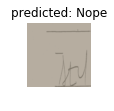

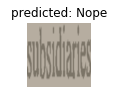

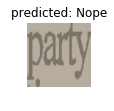

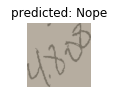

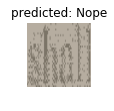

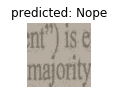

In [10]:
visualize_model(model_ft)

In [11]:
torch.save(model_ft,'/home/dev2/Sanjana/resnet_model/resnet_model_more_data1.pth')

In [12]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

test_transforms = transforms.Compose([transforms.Resize((64, 64)),
transforms.ToTensor()])
# file_path = 'runtime_videos/'
# runtime_path = 'runtime/'
model_path ='/home/dev2/Sanjana/resnet_model/resnet_model_more_data1.pth'
results_dict = dict()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft1 = torch.load(model_path)
model_ft1 = model_ft1.to(device)
model_ft1.eval()
image = cv2.imread(r'/home/dev2/Sanjana/allimagesfromdocs1/image1__0000.png')
#print(image)
#image = cv2.imread(runtime_path+f)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
image_tensor = test_transforms(image).float()
image_tensor = image_tensor.unsqueeze_(0)
input = Variable(image_tensor)
input = input.to(device)
output = model_ft1(input)
index = output.data.cpu().numpy().argmax()


In [13]:
print(output)

tensor([[ 0.9667, -0.4232]], grad_fn=<AddmmBackward>)


In [14]:
print(index)

0


In [15]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image
import os,shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import glob
test_transforms = transforms.Compose([transforms.Resize((64, 64)),
transforms.ToTensor()])
# file_path = 'runtime_videos/'
# runtime_path = 'runtime/'
model_path ='/home/dev2/Sanjana/resnet_model/resnet_model_more_data1.pth'
results_dict = dict()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft1 = torch.load(model_path)
model_ft1 = model_ft1.to(device)
model_ft1.eval()

data_path = os.path.join(r'/home/dev2/1tb/SANJANA/all_images','*.png')
files = glob.glob(data_path)
data=[]
docxnope=[]
print(len(files))
for f1 in files:
    image = cv2.imread(f1)
    #print(image)
    #image = cv2.imread(runtime_path+f)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model_ft1(input)
    index = output.data.cpu().numpy().argmax()
    if index == 1: 
        #print("legalok")
        data.append('legalok')
        docxnope.append(f1)
        if os.path.isfile(f1):
            shutil.copy(f1, r'/home//dev2/1tb/SANJANA/LegalokImages1')                

    else:
        pass

print("done")

68507
done


In [16]:
print("hi")


hi
